# Experiments Results Analysis

In the following notebook we will analyze the preformance of a single SSM (Falcon3-Mamba-7B-Instruct) and a single LLM (Llama-3.1-8B-Instruct).<br>
Those are two instruction models with similar sizes (7.27B vs 8.03B params).<br>
For each model we'll examine the following:
* `gold_index_change` task with 10,20 and 30 documents AND will compare the `openbook_random` and `closedbook` prompting modes.
* `num_docs_change` with gold index of 0,4 and 9 AND will compare the `openbook_random` and `closedbook` prompting modes.

After those are done - we'll compare the SSM and LLM performance. 

## Utils

* matplotlib plots handling
* test results statistics calculation
* test result object loading

In [ ]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any

import matplotlib.pyplot as plt
import statistics
import numpy as np
import json

In [3]:
def load_test_results(results_file_path: str) -> Dict[str, Any]:
    with open(results_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [4]:
def get_scores_mean(scores: List[float], precision: Optional[int] = 4) -> float:
    if precision < 0:
        raise ValueError("'precision' can't be a negative number.")
    return round(statistics.mean(scores), precision)

In [32]:
def plot_metric_over_documents(
    x_values: List[int],
    y_values_list: List[List[float]],
    series_labels: List[str],
    title: Optional[str] = "Metric over Documents",
    xtitle: Optional[str] = "Gold Index",
    ytitle: Optional[str] = "Metric Mean",
    closedbook_mean: Optional[float] = None,
    figsize: Optional[Tuple[int, int]] = (10, 6)
) -> None:

    plt.figure(figsize=figsize)
    
    for y_values, label in zip(y_values_list, series_labels):
        plt.plot(x_values, y_values, marker="o", label=label)

    if closedbook_mean is not None and len(y_values_list) == 1:
        plt.axhline(
            y=closedbook_mean,
            color="red",
            linestyle="--",
            label="closedbook"
        )

    plt.xticks(np.arange(0, max(x_values)+1, 2))

    plt.title(title, weight="bold")
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def populate_plot_data_lists(
    data: Dict[str, Any],
    scores_eval: List[float],
    x_values: Optional[List[int]] = None,
    num_prompt_tokens: Optional[List[int]] = None,
    sort_keys: Optional[bool] = True
) -> str:

    metric = ""
    keys = list(data["experiments"].keys())
    if sort_keys is True:
        keys = sorted(keys, key=lambda x: [int(xi) for xi in x.split("_") if xi.isdigit()][0])

    for key in keys:
        if "gold_at_" in key:
            str_to_replace = "gold_at_"
        elif "_total_documents" in key:
            str_to_replace = "_total_documents"
        else:
            raise ValueError(f"Unidentified results dict key {key}")

        if x_values is not None:
            x_val = int(key.replace(str_to_replace, ""))
            x_values.append(x_val)

        item = data["experiments"][key]
        mean = get_scores_mean(item["scores"])
        scores_eval.append(mean)

        if num_prompt_tokens is not None:
            num_prompt_tokens.extend(item["num_prompt_tokens"])

        if metric == "":
            metric = item["metric"]
        else:
            if item["metric"] != metric:
                raise Exception("Inconsistent results scores metric")

    return metric

In [7]:
def plot_single_model_results_data(
    openbook_path: str,
    closedbook_path: str
) -> None:

    openbook_data = load_test_results(openbook_path)
    openbook_scores_eval = []
    num_prompt_tokens = []
    x_values = []

    metric = populate_plot_data_lists(
        data=openbook_data,
        x_values=x_values,
        scores_eval=openbook_scores_eval,
        num_prompt_tokens=num_prompt_tokens
    )

    closedbook_data = load_test_results(closedbook_path)
    closedbook_scores = closedbook_data["experiments"]["closedbook"]["scores"]
    closedbook_mean = get_scores_mean(closedbook_scores)

    # cuts the HuggingFace repo and leaves only the model name
    short_model_name = openbook_data["model"].split("/")[-1]
    experiment_type = openbook_data["experiment_type"]
    num_docs = openbook_data["num_documents"]

    graph_title = f"{short_model_name}\n" \
        + f"{experiment_type} with {num_docs} total documents, " \
        + f"Avg prompt length: {round(statistics.mean(num_prompt_tokens), 2)} tokens"
    ytitle = f"Performance [metric: {metric}]"

    plot_metric_over_documents(
        x_values=x_values,
        y_values_list=[openbook_scores_eval],
        series_labels=[short_model_name.lower()],
        title=graph_title,
        xtitle="Gold Index [document with answer]",
        ytitle=ytitle,
        closedbook_mean=closedbook_mean
    )

In [8]:
def validate_models_data_consistency(data: List[Any], param_name: str) -> None:
    if data[0] != data[-1]:
        raise Exception(f"Can't compare two model performance of different {param_name}")

In [9]:
def plot_two_models_comparison(openbook_paths: List[str]) -> None:
    
    openbook_datas = [load_test_results(openbook_path) for openbook_path in openbook_paths]
    openbook_scores_evals = [[], []]
    x_values = []
    metrics = []

    for i in range(2):
        metric = populate_plot_data_lists(
            data=openbook_datas[i],
            x_values=x_values if i == 0 else None,
            scores_eval=openbook_scores_evals[i]
        )
        metrics.append(metric)

    validate_models_data_consistency(data=metrics, param_name="metrics")

    short_model_names = []
    experiment_types = []
    num_docs_list = []
    for openbook_data in openbook_datas:
        # cuts the HuggingFace repo and leaves only the model name
        short_model_names.append(openbook_data["model"].split("/")[-1])
        experiment_types.append(openbook_data["experiment_type"])
        num_docs_list.append(openbook_data["num_documents"])

    validate_models_data_consistency(data=experiment_types, param_name="experiments")
    validate_models_data_consistency(data=num_docs_list, param_name="number of documents")


    graph_title = f"{short_model_names[0]} vs {short_model_names[-1]}\n" \
        + f"{experiment_types[0]} with {num_docs_list[0]} total documents"
    ytitle = f"Performance [metric: {metrics[0]}]"

    plot_metric_over_documents(
        x_values=x_values,
        y_values_list=openbook_scores_evals,
        series_labels=short_model_names,
        title=graph_title,
        xtitle="Gold Index [document with answer]",
        ytitle=ytitle
    )

### Utils tests

In [ ]:
test_file_path = list(Path("./results").rglob(f"*json"))[0]
results = load_test_results(test_file_path)
results

In [ ]:
get_scores_mean(results["experiments"]["gold_at_0"]["scores"])

In [ ]:
plot_metric_over_documents([0, 4, 9], [[0.6, 0.4, 0.5]], ["falcon-mamaba"], closedbook_mean=0.42)

In [ ]:
plot_metric_over_documents([0, 4, 9], [[0.6, 0.4, 0.5], [0.67, 0.58, 0.61]], ["falcon-mamaba", "llama-31"])

## Falcon3-Mamba-7B-Instruct Analysis (SSM)

### Gold Index change

In [14]:
falcon_closedbook_path = "../results/Falcon3-Mamba-7B-Instruct/gold_idx_change_experiment/closedbook_prompting"
falcon_closedbook_file = list(Path(falcon_closedbook_path).glob(f"*json"))[0]
falcon_openbook_path = "../results/Falcon3-Mamba-7B-Instruct/gold_idx_change_experiment/openbook_prompting_mode"

10 total documents

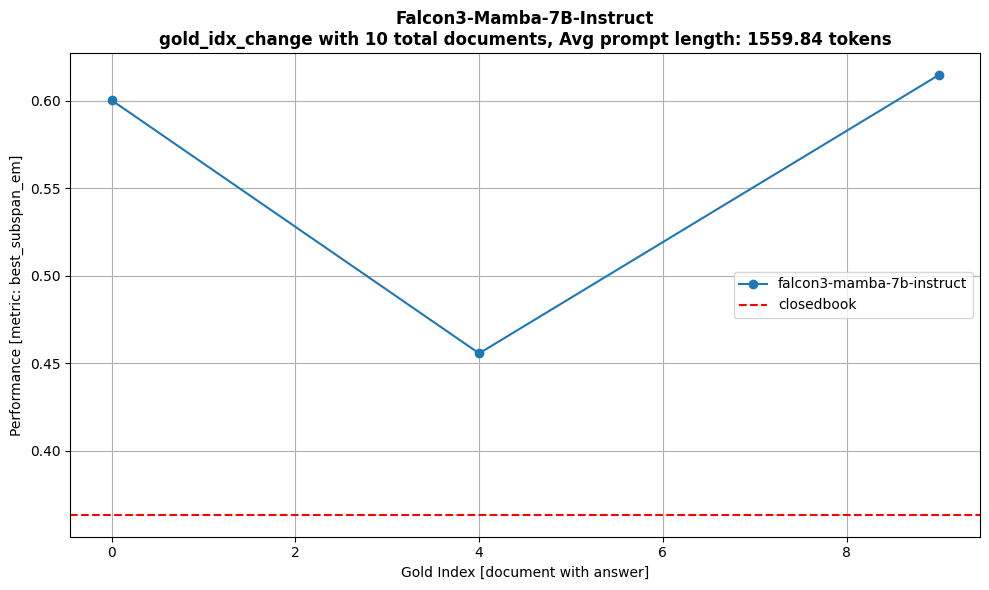

In [33]:
falcon_openbook_file_10_docs = list(Path(f"{falcon_openbook_path}/10_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_10_docs,
    closedbook_path=falcon_closedbook_file
)

20 total documents

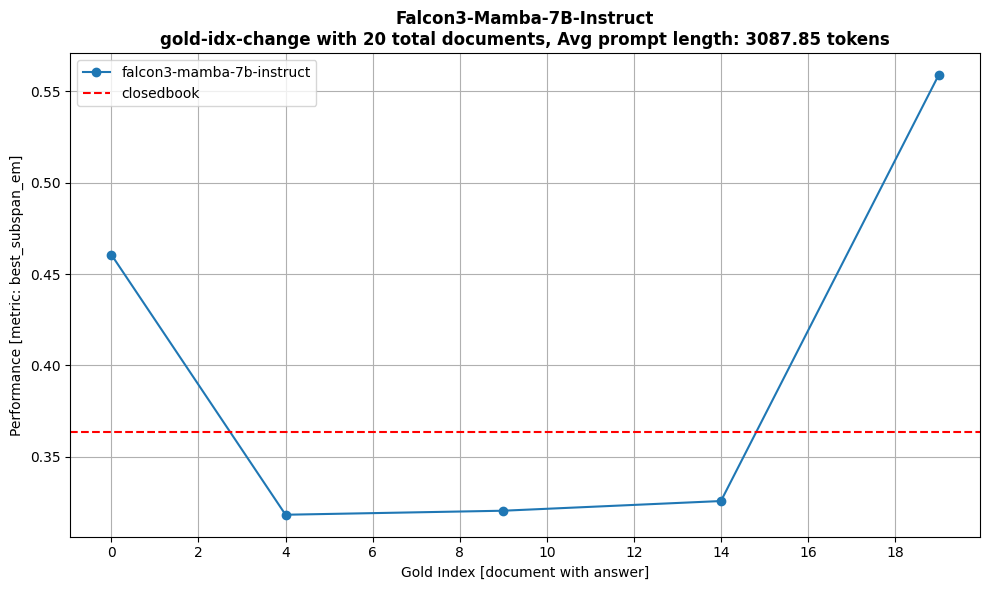

In [97]:
falcon_openbook_file_20_docs = list(Path(f"{falcon_openbook_path}/20_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_20_docs,
    closedbook_path=falcon_closedbook_file
)

30 total documents

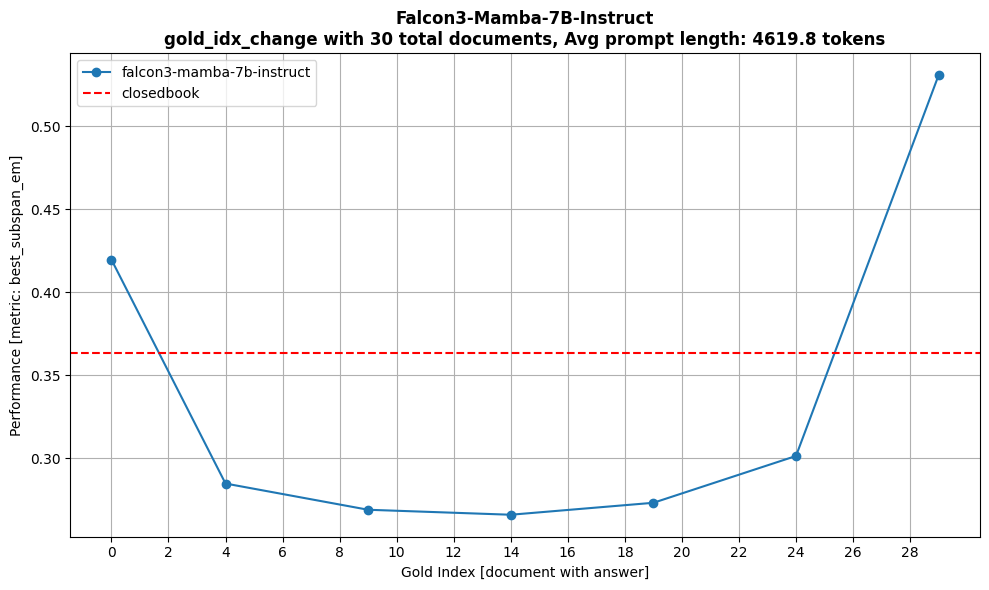

In [ ]:
falcon_openbook_file_30_docs = list(Path(f"{falcon_openbook_path}/30_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=falcon_openbook_file_30_docs,
    closedbook_path=falcon_closedbook_file
)

## Llama-3.1-8B-Instruct Analysis (LLM)

### Gold Index Change

In [60]:
llama_closedbook_path = "./results/Llama-3.1-8B-Instruct/gold_idx_change_experiment/closedbook_prompting"
llama_closedbook_file = list(Path(llama_closedbook_path).glob(f"*json"))[0]
llama_openbook_path = "./results/Llama-3.1-8B-Instruct/gold_idx_change_experiment/openbook_prompting_mode"

10 total documents

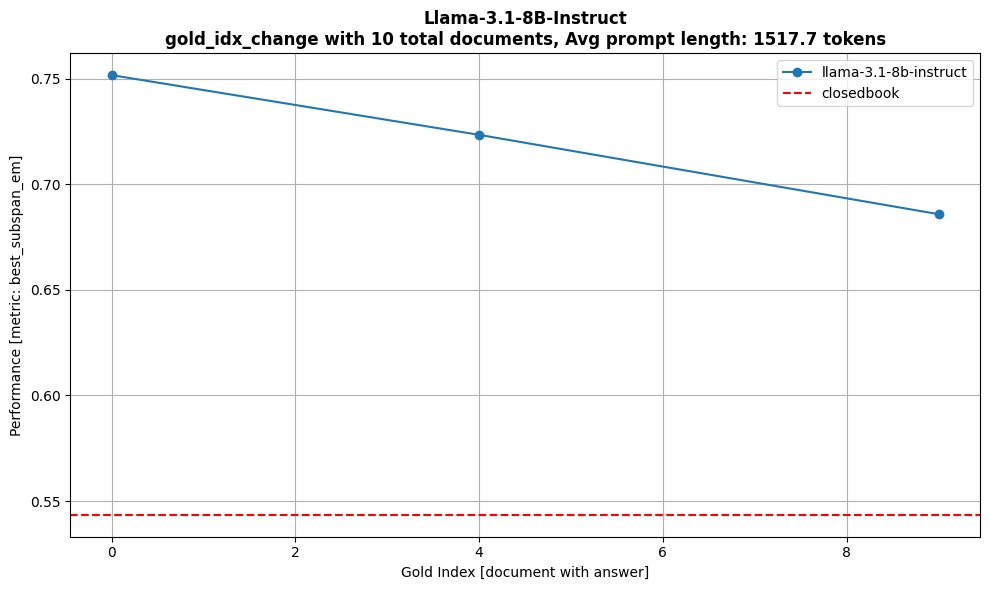

In [100]:
llama_openbook_file_10_docs = list(Path(f"{llama_openbook_path}/10_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_10_docs,
    closedbook_path=llama_closedbook_file
)

20 total documents

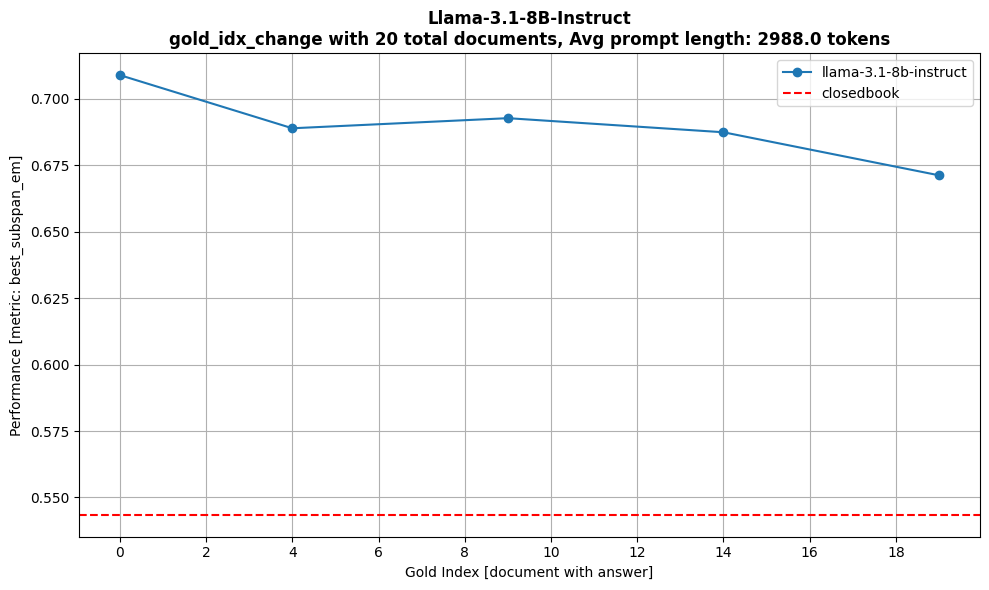

In [101]:
llama_openbook_file_20_docs = list(Path(f"{llama_openbook_path}/20_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_20_docs,
    closedbook_path=llama_closedbook_file
)

30 total documents

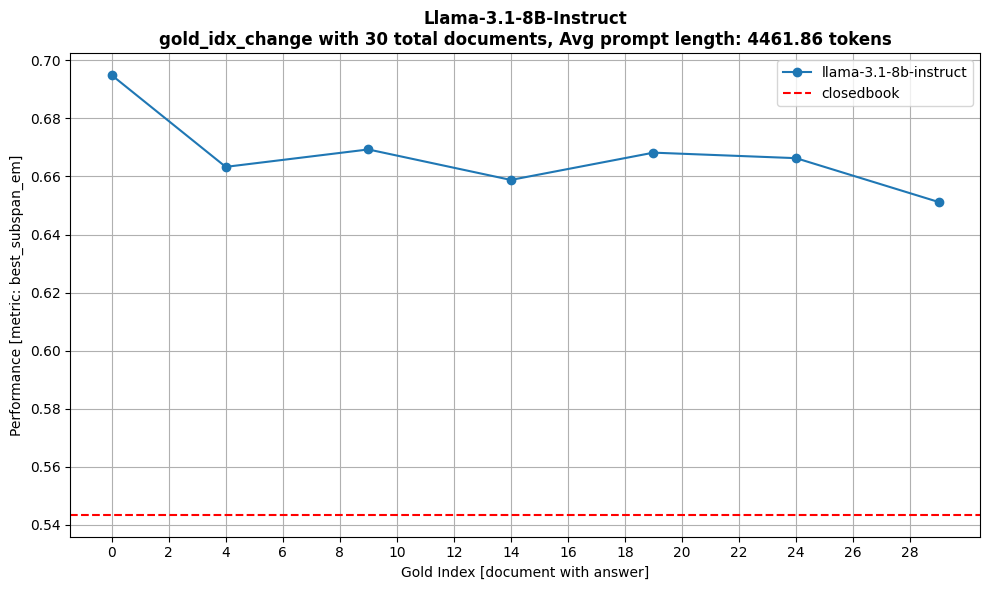

In [102]:
llama_openbook_file_30_docs = list(Path(f"{llama_openbook_path}/30_docs").glob(f"*json"))[0]
plot_single_model_results_data(
    openbook_path=llama_openbook_file_30_docs,
    closedbook_path=llama_closedbook_file
)

## Falcon - Llama Comparison (SSM vs LLM)

### Gold Index Change

10 total documents

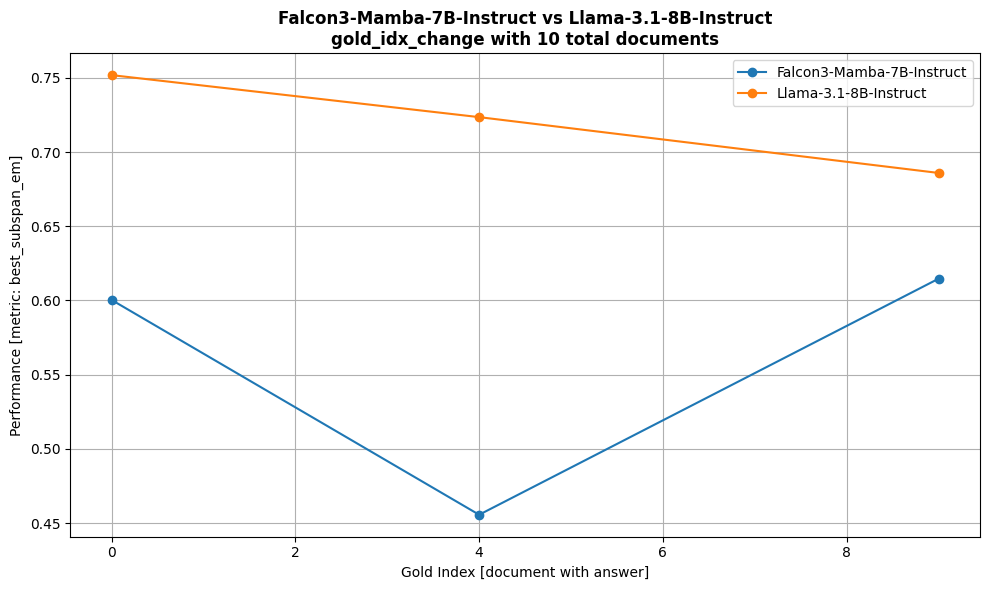

In [104]:
plot_two_models_comparison([falcon_openbook_file_10_docs, llama_openbook_file_10_docs])

20 total documents

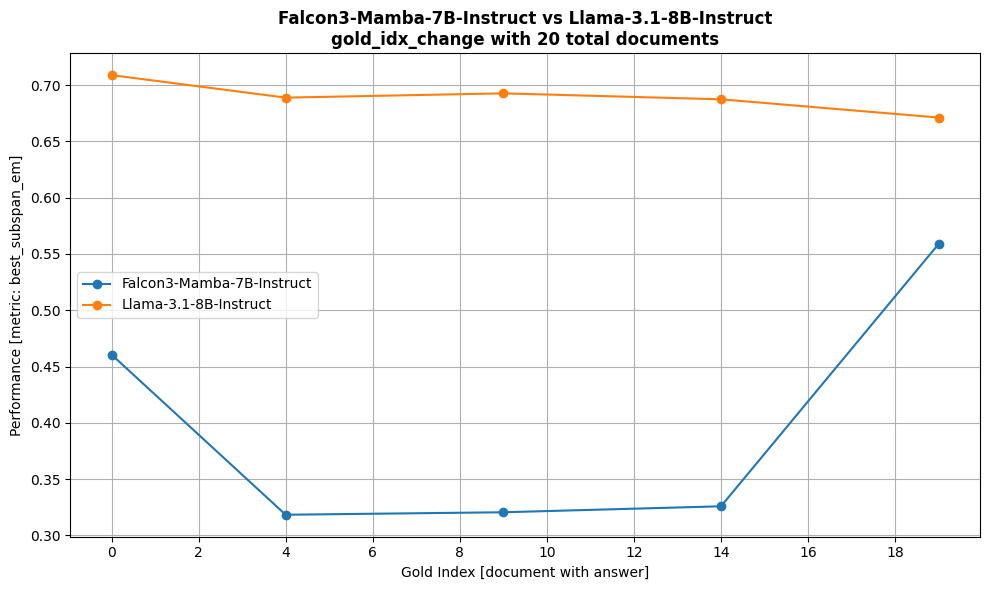

In [105]:
plot_two_models_comparison([falcon_openbook_file_20_docs, llama_openbook_file_20_docs])

30 total documents

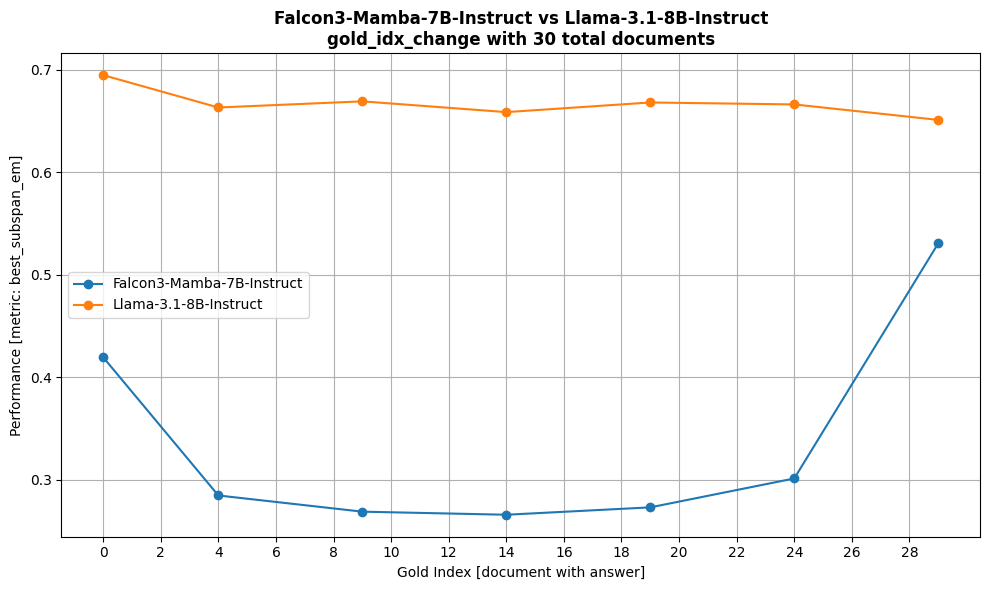

In [106]:
plot_two_models_comparison([falcon_openbook_file_30_docs, llama_openbook_file_30_docs])